# **Distal tibiofibular joint segmentation in CT**
## *AUNet with all slices + data augmentation*
**Authors:** Isha Dev, Liora Dsilva

In [ ]:
# Set up and imports

import os
import argparse
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision import transforms
from matplotlib.colors import ListedColormap, BoundaryNorm
import torch.nn.functional as F
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt
from collections import Counter
import albumentations as A

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Load and process data**

In [ ]:
# Load data and get keys
DATA_PATH = '/content/drive/MyDrive/DLMI Project/Project_Data/AnkleDataset_DS4.npz'
data = np.load(DATA_PATH)
image_keys = sorted([k for k in data if k.startswith("image_")])
fib_keys = sorted([k for k in data if k.startswith("fibula_")])
tib_keys = sorted([k for k in data if k.startswith("tibia_")])
tal_keys = sorted([k for k in data if k.startswith("talus_")])

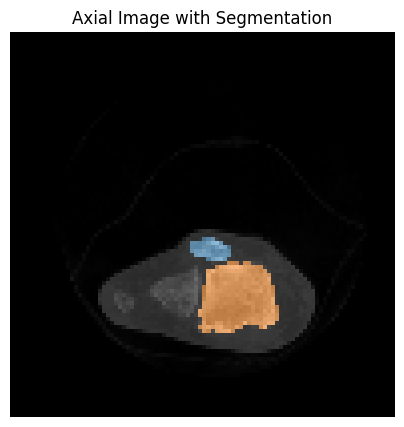

In [ ]:
# Plot an axial Example
i = 2
img = data[f'image_{i}']
seg = np.zeros_like(img, dtype=np.uint8)
seg[data[f'fibula_{i}'] == 1] = 1
seg[data[f'tibia_{i}'] == 1]  = 2
seg[data[f'talus_{i}'] == 1]  = 3

axial = img[:, :, 87]
mask  = seg[:, :, 87]
cmap  = ListedColormap(['black', '#1f77b4', '#2ca02c', '#ff7f0e'])
plt.figure(figsize=(5,5))
plt.imshow(axial, cmap='gray')
plt.imshow(mask, cmap=cmap, alpha=0.5)
plt.title("Axial Image with Segmentation")
plt.axis('off'); plt.show()

In [ ]:
# Transforms for training data
def get_training_transform():
    return A.Compose([
        A.Affine(
            scale=(0.98, 1.02),
            translate_percent=(0.01, 0.01),
            rotate=(-5, 5),
            p=0.3
        ),
        A.RandomBrightnessContrast(
            brightness_limit=0.10, contrast_limit=0.10, p=0.3
        ),
        A.GaussNoise(p=0.2),
        A.ElasticTransform(
            alpha=0.2, sigma=5, approximate=True, p=0.2
        )
    ])

train_transform = get_training_transform()

class AxialDataset(Dataset):
    def __init__(self, npz_path, include_ids=None, transform = None, crop_size=128, min_voxels=0):
        # Load data from the .npz file
        self.data = np.load(npz_path)
        self.crop_size = crop_size          # Target size for output slices
        self.transform = transform          # Data augmentation
        self.min_voxels = min_voxels
        self.index_map = []

        # Containers
        self.images = []
        self.fibs = []
        self.tibs = []
        self.tals = []
        self.patient_ids = []

        # Collect axial images
        for k in sorted(self.data):
            if k.startswith("image_"):
                pid = int(k.split("_")[1])
                if include_ids is not None and pid not in include_ids:
                    continue
                self.images.append(self.data[k])
                self.patient_ids.append(pid)

        # Collect corresponding fibula, tibia, talus masks
        for key, target in zip(['fibula', 'tibia', 'talus'], [self.fibs, self.tibs, self.tals]):
            for k in sorted(self.data):
                if k.startswith(f"{key}_"):
                    pid = int(k.split("_")[1])
                    if include_ids is not None and pid not in include_ids:
                        continue
                    target.append(self.data[k])

        # Slice indices with minimum 10 voxels of segmentation mask
        for i, (img, fib, tib, tal) in enumerate(zip(self.images, self.fibs, self.tibs, self.tals)):
            for z in range(img.shape[2]):
                # Build a label map (0=background, 1=fibula, 2=tibia, 3=talus)
                label = (fib[:, :, z] > 0) * 1 + (tib[:, :, z] > 0) * 2 + (tal[:, :, z] > 0) * 3
                if (label > 0).sum() >= self.min_voxels:
                    self.index_map.append((i, z))

    def __len__(self):
        # Number of eligible slices for training
        return len(self.index_map)

    def __getitem__(self, idx):
        # Get volume index and slice index
        i, z = self.index_map[idx]

        # Get corresponding image slice
        img = self.images[i][:, :, z]

        # Get binary masks
        fib = self.fibs[i][:, :, z]
        tib = self.tibs[i][:, :, z]
        tal = self.tals[i][:, :, z]

        # Construct a label map
        label = np.zeros_like(img, dtype=np.uint8)
        label[fib > 0] = 1
        label[tib > 0] = 2
        label[tal > 0] = 3

        img = self.pad_crop(img).astype(np.float32)
        label = self.pad_crop(label).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=img, mask=label)
            img = augmented['image']
            label = augmented['mask']

        label = label.astype(np.uint8)

        img = torch.from_numpy(img).float().unsqueeze(0)  # [1, H, W]
        label = torch.from_numpy(label).long()
        return img, label

    def pad_crop(self, x):
        H, W = x.shape
        pad_h = max(0, self.crop_size - H)
        pad_w = max(0, self.crop_size - W)

        # Symmetric padding
        x = np.pad(x,
                   ((pad_h // 2, pad_h - pad_h // 2),
                    (pad_w // 2, pad_w - pad_w // 2)),
                   mode='constant')

        # Center crop
        return x[:self.crop_size, :self.crop_size]

In [ ]:
def get_patient_ids(npz_path):
  # Get files and patient ids
  data = np.load(npz_path)
  return sorted([int(k.split("_")[1]) for k in data if k.startswith("image_")])

def split_patient_ids(patient_ids, seed=42, train_frac=0.7, val_frac=0.2):
  # Random split of patient IDs into train/val/test
  random.seed(seed)
  random.shuffle(patient_ids)
  N = len(patient_ids)
  train_ids = patient_ids[:int(train_frac * N)]
  val_ids = patient_ids[int(train_frac * N):int((train_frac + val_frac) * N)]
  test_ids = patient_ids[int((train_frac + val_frac) * N):]
  return train_ids, val_ids, test_ids

In [ ]:
# Get split patient ids
all_patient_ids = get_patient_ids(DATA_PATH)
train_ids, val_ids, test_ids = split_patient_ids(all_patient_ids)

# Create datasets
train_ds = AxialDataset(DATA_PATH, include_ids=train_ids, transform=train_transform)
val_ds = AxialDataset(DATA_PATH, include_ids=val_ids)
test_ds = AxialDataset(DATA_PATH, include_ids=test_ids)

# Data loaders with batching
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
from collections import Counter

def compute_class_weights(dataset):
    counter = Counter()
    for _, label in dataset:
        for c in range(4):
            counter[c] += (label == c).sum().item()
    freqs = np.array([counter[c] for c in range(4)])
    weights = 1.0 / (freqs + 1e-6)
    return torch.tensor(weights / weights.sum(), dtype=torch.float32)

class_weights = compute_class_weights(train_ds)

### **Model Architecture and Metrics**

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        # Gating signal transformation
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        # Encoder signal transformation (same as above)
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        # Combine gating and encoder features
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),  # Compress
            nn.BatchNorm2d(1),
            nn.Sigmoid()  # Normalize to [0, 1]
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)  # Combine the transformed features
        psi = self.psi(psi)       # Get attention map
        return x * psi            # Apply attention to encoder features

class AttentionUNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=4, base_filters=32, dropout=0.1):
        super().__init__()
        # Conv block with BN, ReLU, Dropout
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        # Encoder (downsampling)
        self.enc1 = conv_block(in_ch, base_filters)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = conv_block(base_filters, base_filters * 2)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = conv_block(base_filters * 2, base_filters * 4)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.center = conv_block(base_filters * 4, base_filters * 8)

        # Decoder (upsampling, attention gate)
        self.up3 = nn.ConvTranspose2d(base_filters * 8, base_filters * 4, 2, stride=2)
        self.att3 = AttentionBlock(F_g=base_filters * 4, F_l=base_filters * 4, F_int=base_filters * 2)
        self.dec3 = conv_block(base_filters * 8, base_filters * 4)  # Skip + upsampled input

        self.up2 = nn.ConvTranspose2d(base_filters * 4, base_filters * 2, 2, stride=2)
        self.att2 = AttentionBlock(F_g=base_filters * 2, F_l=base_filters * 2, F_int=base_filters)
        self.dec2 = conv_block(base_filters * 4, base_filters * 2)

        self.up1 = nn.ConvTranspose2d(base_filters * 2, base_filters, 2, stride=2)
        self.att1 = AttentionBlock(F_g=base_filters, F_l=base_filters, F_int=base_filters // 2)
        self.dec1 = conv_block(base_filters * 2, base_filters)

        # Output classifier
        self.out = nn.Conv2d(base_filters, out_ch, kernel_size=1)

    # Forward pass
    def forward(self, x):
        # Encoder forward pass
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        center = self.center(self.pool3(e3))

        # Decoder forward pass with skip connections and attention gates
        d3 = self.up3(center)  # Upsample center output
        d3 = self.dec3(torch.cat([self.att3(d3, e3), d3], dim=1))  # Attention on e3

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([self.att2(d2, e2), d2], dim=1))  # Attention on e2

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([self.att1(d1, e1), d1], dim=1))  # Attention on e1

        return self.out(d1)  # Final logits

def dice_score(preds, targets, num_classes=4, eps=1e-6):
    # Convert to one-hot encoding
    preds = F.one_hot(preds, num_classes).permute(0, 3, 1, 2).float()
    targets = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()

    # Compute per-class intersection and union
    intersection = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))

    # Dice score with smoothing
    dice = (2 * intersection + eps) / (union + eps)

    mean_dice = dice.mean().item()  # Mean over batch and classes
    class_dice = dice.mean(dim=0).tolist()  # Per-class Dice averaged over batch
    return mean_dice, class_dice

def pixel_accuracy(preds, targets):
  correct = (preds == targets).float()
  return correct.sum().item() / correct.numel()

def train_model_sanity(model, train_loader, val_loader, class_weights, device, epochs=25, lr=1e-4, log_csv_path=None):
  model.to(device)
  # Weighted cross-entropy loss
  criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  best_dice = 0
  log_rows = [] # CSV setup
  header = ["epoch", "train_loss", "val_loss", "val_dice", "pixel_acc"] + [f"class_{i}_dice" for i in range(class_weights.shape[0])]

  # Training
  for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for img, label in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} - Training"):
        img, label = img.to(device), label.to(device)

        optimizer.zero_grad()
        logits = model(img)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    all_dices = []
    all_class_dices = []
    acc_total = 0
    with torch.no_grad():
        for img, label in tqdm(val_loader, desc="Validating"):
            img, label = img.to(device), label.to(device)
            logits = model(img)
            loss = criterion(logits, label)
            val_loss += loss.item()

            preds = logits.argmax(dim=1)
            mean_dice, class_dice = dice_score(preds, label)
            acc = pixel_accuracy(preds, label)

            all_dices.append(mean_dice)
            all_class_dices.append(torch.tensor(class_dice))
            acc_total += acc

    avg_val_loss = val_loss / len(val_loader)
    avg_dice = sum(all_dices) / len(all_dices)
    avg_class_dice = torch.stack(all_class_dices).mean(dim=0).tolist()
    avg_acc = acc_total / len(val_loader)

    # Log metrics
    print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Dice={avg_dice:.4f}, Acc={avg_acc:.4f}")
    print("Per-Class Dice:", ["{:.4f}".format(d) for d in avg_class_dice])

    # CSV logging
    if log_csv_path:
        row = [epoch, avg_train_loss, avg_val_loss, avg_dice, avg_acc] + avg_class_dice
        log_rows.append(row)

    # Save best model
    if avg_dice > best_dice:
        best_dice = avg_dice
        torch.save(model.state_dict(), "/content/drive/MyDrive/DLMI Project/Isha_Models/Results/Model_8/best_model.pth")

  if log_csv_path:
      with open(log_csv_path, 'w', newline='') as f:
          writer = csv.writer(f)
          writer.writerow(header)
          writer.writerows(log_rows)

  print("Training complete. Best Dice: {:.4f}".format(best_dice))

### **Train Model**

In [ ]:
# Device, model and training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
model = AttentionUNet(in_ch=1, out_ch=4, dropout=0.1)
train_model_sanity(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    class_weights=class_weights,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    epochs=35,
    lr=1e-4,
    log_csv_path="/content/drive/MyDrive/DLMI Project/Isha_Models/Results/Model_8/train_log.csv"
)

Validating: 100%|██████████| 286/286 [00:02<00:00, 136.43it/s]


Epoch 1: Train Loss=1.1463, Val Loss=0.8614, Dice=0.2850, Acc=0.8563
Per-Class Dice: ['0.9180', '0.0848', '0.0837', '0.0537']


Validating: 100%|██████████| 286/286 [00:01<00:00, 148.52it/s]


Epoch 2: Train Loss=0.8680, Val Loss=0.5945, Dice=0.4373, Acc=0.9281
Per-Class Dice: ['0.9608', '0.1602', '0.2631', '0.3651']


Validating: 100%|██████████| 286/286 [00:01<00:00, 152.03it/s]


Epoch 3: Train Loss=0.7360, Val Loss=0.4482, Dice=0.5114, Acc=0.9465
Per-Class Dice: ['0.9706', '0.2484', '0.3572', '0.4693']


Validating: 100%|██████████| 286/286 [00:01<00:00, 148.73it/s]


Epoch 4: Train Loss=0.6620, Val Loss=0.3719, Dice=0.6068, Acc=0.9719
Per-Class Dice: ['0.9855', '0.4173', '0.4083', '0.6160']


Validating: 100%|██████████| 286/286 [00:02<00:00, 139.28it/s]


Epoch 5: Train Loss=0.5779, Val Loss=0.2935, Dice=0.5976, Acc=0.9797
Per-Class Dice: ['0.9899', '0.4208', '0.5219', '0.4580']


Validating: 100%|██████████| 286/286 [00:01<00:00, 151.67it/s]


Epoch 6: Train Loss=0.5599, Val Loss=0.2046, Dice=0.6792, Acc=0.9808
Per-Class Dice: ['0.9901', '0.4316', '0.5460', '0.7492']


Validating: 100%|██████████| 286/286 [00:01<00:00, 146.47it/s]


Epoch 7: Train Loss=0.5057, Val Loss=0.1823, Dice=0.5806, Acc=0.9730
Per-Class Dice: ['0.9861', '0.5752', '0.4210', '0.3400']


Validating: 100%|██████████| 286/286 [00:01<00:00, 148.82it/s]


Epoch 8: Train Loss=0.5088, Val Loss=0.1467, Dice=0.7341, Acc=0.9889
Per-Class Dice: ['0.9944', '0.5376', '0.6109', '0.7936']


Validating: 100%|██████████| 286/286 [00:02<00:00, 117.57it/s]


Epoch 9: Train Loss=0.4757, Val Loss=0.1283, Dice=0.6899, Acc=0.9854
Per-Class Dice: ['0.9926', '0.4736', '0.5758', '0.7175']


Validating: 100%|██████████| 286/286 [00:01<00:00, 155.38it/s]


Epoch 10: Train Loss=0.4761, Val Loss=0.1239, Dice=0.7278, Acc=0.9875
Per-Class Dice: ['0.9937', '0.6373', '0.4765', '0.8039']


Validating: 100%|██████████| 286/286 [00:01<00:00, 155.95it/s]


Epoch 11: Train Loss=0.4553, Val Loss=0.1042, Dice=0.7893, Acc=0.9913
Per-Class Dice: ['0.9956', '0.6941', '0.6874', '0.7803']


Validating: 100%|██████████| 286/286 [00:02<00:00, 130.93it/s]


Epoch 12: Train Loss=0.4539, Val Loss=0.1073, Dice=0.7051, Acc=0.9886
Per-Class Dice: ['0.9944', '0.5016', '0.6129', '0.7115']


Validating: 100%|██████████| 286/286 [00:02<00:00, 129.44it/s]


Epoch 13: Train Loss=0.4551, Val Loss=0.1018, Dice=0.5525, Acc=0.9791
Per-Class Dice: ['0.9893', '0.1211', '0.4331', '0.6663']


Validating: 100%|██████████| 286/286 [00:01<00:00, 153.46it/s]


Epoch 14: Train Loss=0.4469, Val Loss=0.1825, Dice=0.3372, Acc=0.9478
Per-Class Dice: ['0.9730', '0.1331', '0.1606', '0.0821']


Validating: 100%|██████████| 286/286 [00:01<00:00, 154.75it/s]


Epoch 15: Train Loss=0.4548, Val Loss=0.0660, Dice=0.7774, Acc=0.9919
Per-Class Dice: ['0.9959', '0.6325', '0.7611', '0.7202']


Validating: 100%|██████████| 286/286 [00:01<00:00, 148.24it/s]


Epoch 16: Train Loss=0.4359, Val Loss=0.0859, Dice=0.7381, Acc=0.9865
Per-Class Dice: ['0.9930', '0.6581', '0.5962', '0.7052']


Validating: 100%|██████████| 286/286 [00:01<00:00, 148.99it/s]


Epoch 17: Train Loss=0.4406, Val Loss=0.0602, Dice=0.7317, Acc=0.9911
Per-Class Dice: ['0.9955', '0.6021', '0.6962', '0.6328']


Validating: 100%|██████████| 286/286 [00:01<00:00, 147.88it/s]


Epoch 18: Train Loss=0.4335, Val Loss=0.0676, Dice=0.7882, Acc=0.9916
Per-Class Dice: ['0.9957', '0.7071', '0.6053', '0.8446']


Validating: 100%|██████████| 286/286 [00:02<00:00, 138.24it/s]


Epoch 19: Train Loss=0.4510, Val Loss=0.0785, Dice=0.7814, Acc=0.9905
Per-Class Dice: ['0.9951', '0.6970', '0.6707', '0.7629']


Validating: 100%|██████████| 286/286 [00:02<00:00, 136.89it/s]


Epoch 20: Train Loss=0.4247, Val Loss=0.0542, Dice=0.8179, Acc=0.9926
Per-Class Dice: ['0.9963', '0.6894', '0.8160', '0.7697']


Validating: 100%|██████████| 286/286 [00:02<00:00, 130.79it/s]


Epoch 21: Train Loss=0.4549, Val Loss=0.0785, Dice=0.6985, Acc=0.9888
Per-Class Dice: ['0.9943', '0.4578', '0.4508', '0.8912']


Validating: 100%|██████████| 286/286 [00:02<00:00, 132.37it/s]


Epoch 22: Train Loss=0.4508, Val Loss=0.0597, Dice=0.7944, Acc=0.9922
Per-Class Dice: ['0.9960', '0.7120', '0.7985', '0.6709']


Validating: 100%|██████████| 286/286 [00:02<00:00, 132.49it/s]


Epoch 23: Train Loss=0.4315, Val Loss=0.0558, Dice=0.6750, Acc=0.9894
Per-Class Dice: ['0.9946', '0.5400', '0.5172', '0.6480']


Validating: 100%|██████████| 286/286 [00:02<00:00, 126.92it/s]


Epoch 24: Train Loss=0.4320, Val Loss=0.0572, Dice=0.8128, Acc=0.9932
Per-Class Dice: ['0.9966', '0.7128', '0.7236', '0.8182']


Validating: 100%|██████████| 286/286 [00:02<00:00, 136.27it/s]


Epoch 25: Train Loss=0.4218, Val Loss=0.0464, Dice=0.8017, Acc=0.9927
Per-Class Dice: ['0.9963', '0.5950', '0.7912', '0.8242']


Validating: 100%|██████████| 286/286 [00:02<00:00, 119.90it/s]


Epoch 26: Train Loss=0.4270, Val Loss=0.0468, Dice=0.7428, Acc=0.9912
Per-Class Dice: ['0.9955', '0.6648', '0.6150', '0.6960']


Validating: 100%|██████████| 286/286 [00:02<00:00, 132.55it/s]


Epoch 27: Train Loss=0.4377, Val Loss=0.0591, Dice=0.7877, Acc=0.9933
Per-Class Dice: ['0.9966', '0.5548', '0.7372', '0.8621']


Validating: 100%|██████████| 286/286 [00:02<00:00, 117.93it/s]


Epoch 28: Train Loss=0.4490, Val Loss=0.1299, Dice=0.5036, Acc=0.9476
Per-Class Dice: ['0.9713', '0.2397', '0.4794', '0.3241']


Validating: 100%|██████████| 286/286 [00:02<00:00, 133.19it/s]


Epoch 29: Train Loss=0.4326, Val Loss=0.0787, Dice=0.5543, Acc=0.9776
Per-Class Dice: ['0.9885', '0.3176', '0.4938', '0.4171']


Validating: 100%|██████████| 286/286 [00:02<00:00, 115.78it/s]


Epoch 30: Train Loss=0.4339, Val Loss=0.0523, Dice=0.8333, Acc=0.9908
Per-Class Dice: ['0.9952', '0.6842', '0.7980', '0.8557']


Validating: 100%|██████████| 286/286 [00:02<00:00, 130.68it/s]


Epoch 31: Train Loss=0.4241, Val Loss=0.0531, Dice=0.8776, Acc=0.9932
Per-Class Dice: ['0.9966', '0.7764', '0.8729', '0.8647']


Validating: 100%|██████████| 286/286 [00:02<00:00, 134.75it/s]


Epoch 32: Train Loss=0.4284, Val Loss=0.0484, Dice=0.8387, Acc=0.9929
Per-Class Dice: ['0.9964', '0.7603', '0.8082', '0.7900']


Validating: 100%|██████████| 286/286 [00:02<00:00, 121.72it/s]


Epoch 33: Train Loss=0.4361, Val Loss=0.0527, Dice=0.8970, Acc=0.9956
Per-Class Dice: ['0.9978', '0.8132', '0.9056', '0.8715']


Validating: 100%|██████████| 286/286 [00:02<00:00, 133.44it/s]


Epoch 34: Train Loss=0.4351, Val Loss=0.1279, Dice=0.6277, Acc=0.9840
Per-Class Dice: ['0.9920', '0.5458', '0.2065', '0.7663']


Validating: 100%|██████████| 286/286 [00:02<00:00, 134.14it/s]

Epoch 35: Train Loss=0.4269, Val Loss=0.0455, Dice=0.8041, Acc=0.9932
Per-Class Dice: ['0.9965', '0.6773', '0.7162', '0.8263']
Training complete. Best Dice: 0.8970


In [ ]:
def plot_training_metrics(log_csv_path, class_labels=["Background", "Fibula", "Tibia", "Talus"]):
    df = pd.read_csv(log_csv_path)
    epochs = df['epoch']

    fig, axs = plt.subplots(1, 4, figsize=(24, 5))

    # Pixel Accuracy
    axs[0].plot(epochs, df['pixel_acc'], label="Pixel Accuracy", color='tab:blue')
    axs[0].set_title("Pixel Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")

    # Mean Dice
    axs[1].plot(epochs, df['val_dice'], label="Val Dice", color='tab:green')
    axs[1].set_title("Mean Dice (Validation)")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Dice Score")

    # Per-Class Dice
    axs[2].plot(epochs, df['val_dice'], label="Mean Dice", linewidth=2)
    for i, label in enumerate(class_labels):
        axs[2].plot(epochs, df[f'class_{i}_dice'], linestyle='--', label=label)
    axs[2].set_title("Per-Class and Mean Dice (Validation)")
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylabel("Dice Score")
    axs[2].legend()

    # Loss (Train + Val)
    axs[3].plot(epochs, df['train_loss'], label="Train Loss", linestyle='--', color='tab:orange')
    axs[3].plot(epochs, df['val_loss'], label="Val Loss", color='tab:red')
    axs[3].set_title("Loss")
    axs[3].set_xlabel("Epoch")
    axs[3].set_ylabel("Loss")
    axs[3].legend()

    plt.tight_layout()

    plt.savefig("/content/drive/MyDrive/DLMI Project/Isha_Models/Results/Model_8/training_metrics.png", bbox_inches='tight')

    plt.show()

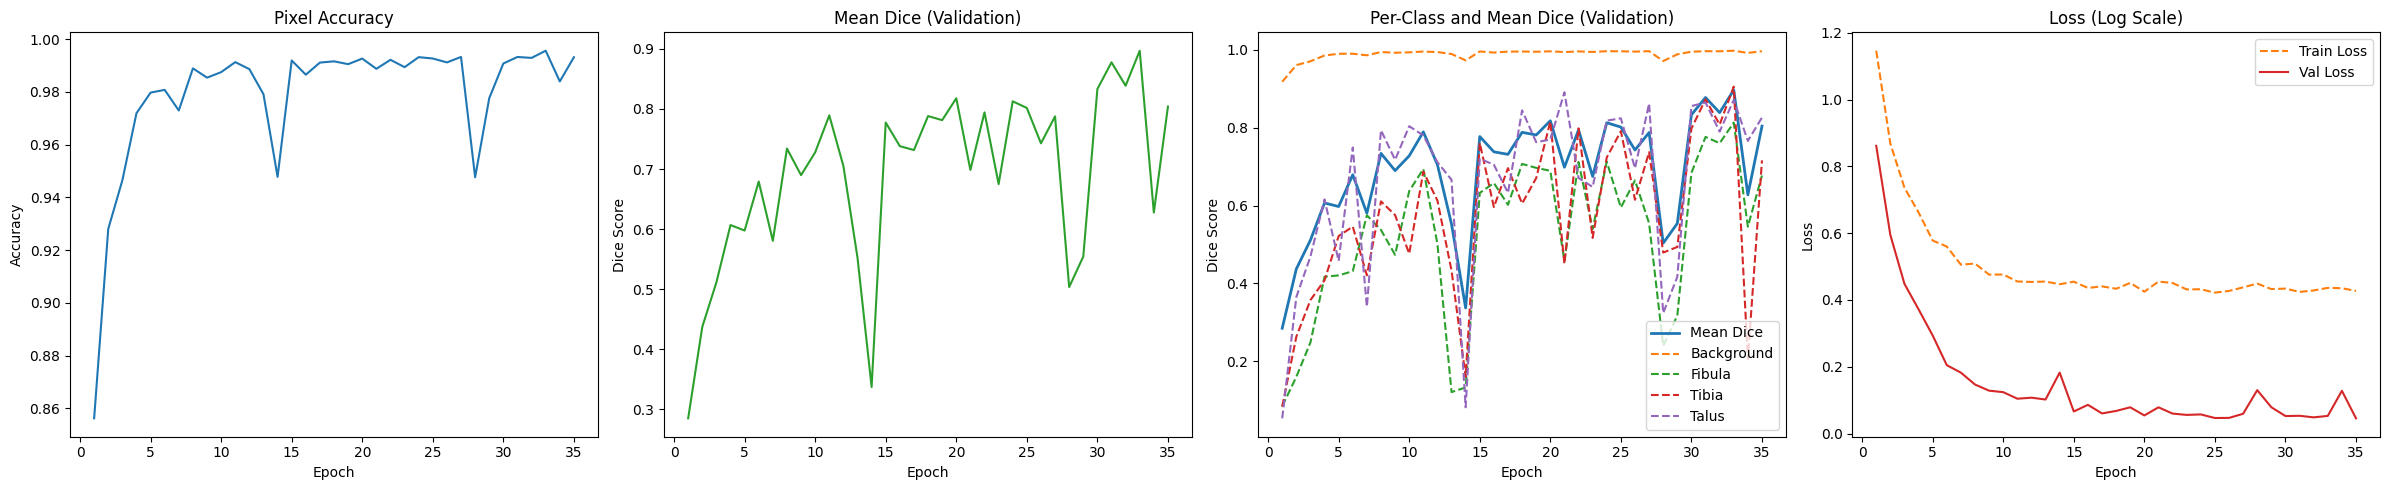

In [ ]:
plot_training_metrics("/content/drive/MyDrive/DLMI Project/Isha_Models/Results/Model_8/train_log.csv")

### **Model Evaluation**

In [ ]:
def evaluate_model(model, test_loader, device, num_classes=4):
    model.eval()
    model.to(device)

    total_loss = 0
    total_acc = 0
    all_dices = []
    all_class_dices = []

    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for img, label in tqdm(test_loader, desc="Evaluating"):
            img, label = img.to(device), label.to(device)

            logits = model(img)
            loss = criterion(logits, label)
            total_loss += loss.item()

            preds = logits.argmax(dim=1)

            # Pixel accuracy
            acc = (preds == label).float().mean().item()
            total_acc += acc

            # Dice
            one_hot_preds = F.one_hot(preds, num_classes).permute(0, 3, 1, 2).float()
            one_hot_labels = F.one_hot(label, num_classes).permute(0, 3, 1, 2).float()

            intersection = (one_hot_preds * one_hot_labels).sum(dim=(2, 3))
            union = one_hot_preds.sum(dim=(2, 3)) + one_hot_labels.sum(dim=(2, 3))
            dice = (2 * intersection + 1e-6) / (union + 1e-6)

            all_dices.append(dice.mean().item())
            all_class_dices.append(dice.mean(dim=0))

    avg_loss = total_loss / len(test_loader)
    avg_acc = total_acc / len(test_loader)
    avg_dice = sum(all_dices) / len(all_dices)
    avg_class_dice = torch.stack(all_class_dices).mean(dim=0).tolist()

    print(f"\nTest Loss: {avg_loss:.4f}")
    print(f"Pixel Accuracy: {avg_acc:.4f}")
    print(f"Mean Dice: {avg_dice:.4f}")
    print("Per-Class Dice:", [f"{d:.4f}" for d in avg_class_dice])

    return {
        "loss": avg_loss,
        "accuracy": avg_acc,
        "mean_dice": avg_dice,
        "per_class_dice": avg_class_dice
    }

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("/content/drive/MyDrive/DLMI Project/Isha_Models/Results/Model_8/best_model.pth"))
metrics = evaluate_model(model, test_loader, device)

Evaluating: 100%|██████████| 144/144 [00:01<00:00, 130.73it/s]


Test Loss: 0.0150
Pixel Accuracy: 0.9967
Mean Dice: 0.9063
Per-Class Dice: ['0.9984', '0.8198', '0.8990', '0.9081']


In [ ]:
def plot_random_predictions(model, dataset, device, num_samples=3):
    model.eval()
    model.to(device)

    class_colors = {
        1: (1, 0, 0),   # Fibula - red
        2: (0, 1, 0),   # Tibia - green
        3: (0, 0, 1)    # Talus - blue
    }

    # Randomly sample valid indices with enough labels
    valid_indices = [i for i in range(len(dataset)) if (dataset[i][1] > 0).sum() >= 0]
    if len(valid_indices) == 0:
        print("No labeled slices found!")
        return

    sampled_indices = random.sample(valid_indices, min(num_samples, len(valid_indices)))
    imgs = []
    labels = []

    for idx in sampled_indices:
        img, label = dataset[idx]
        imgs.append(img)
        labels.append(label)

    imgs = torch.stack(imgs).to(device)
    labels = torch.stack(labels)

    with torch.no_grad():
        preds = model(imgs).argmax(dim=1).cpu()

    for i in range(len(sampled_indices)):
        img = imgs[i][0].cpu().numpy()
        label = labels[i].numpy()
        pred = preds[i].numpy()

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))

        axs[0].imshow(img, cmap='gray')
        axs[0].set_title("Input Image")
        axs[0].axis('off')

        axs[1].imshow(img, cmap='gray')
        for cls, color in class_colors.items():
            axs[1].imshow((label == cls).astype(float)[..., None] * color, alpha=0.4)
        axs[1].set_title("Ground Truth")
        axs[1].axis('off')

        axs[2].imshow(img, cmap='gray')
        for cls, color in class_colors.items():
            axs[2].imshow((pred == cls).astype(float)[..., None] * color, alpha=0.4)
        axs[2].set_title("Prediction")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

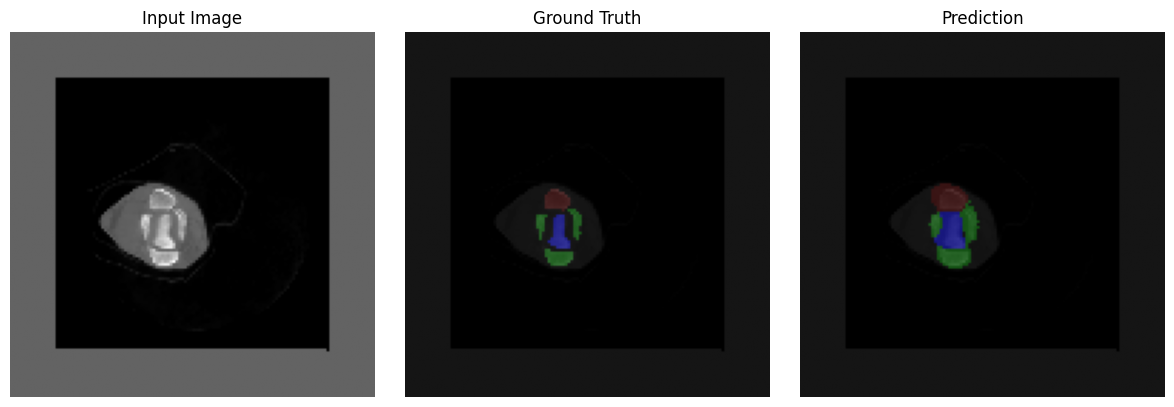

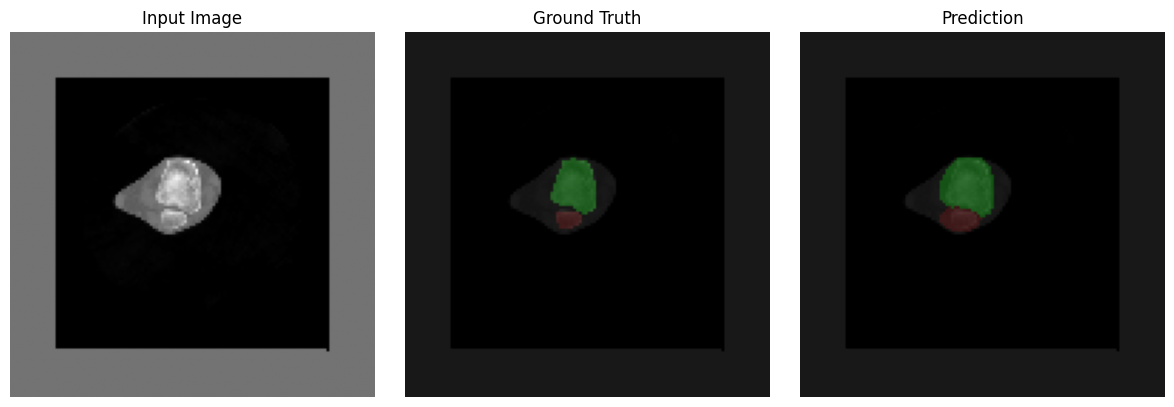

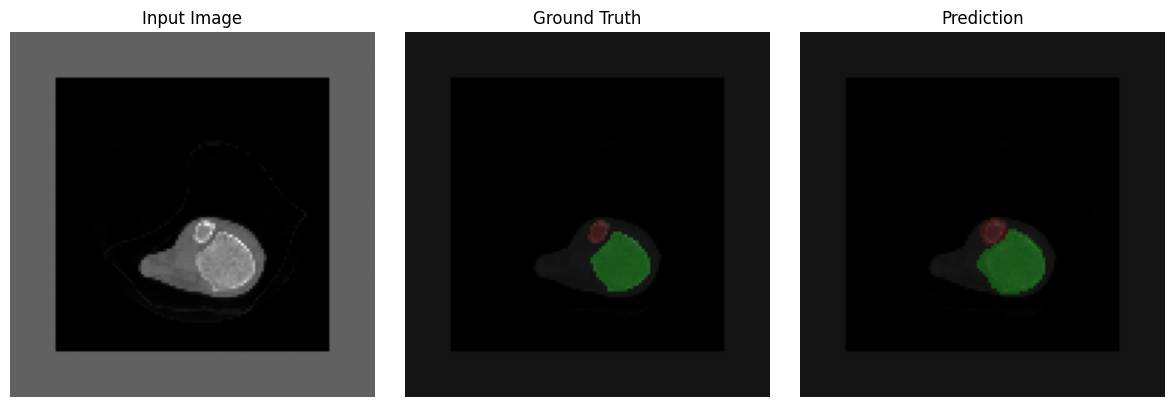

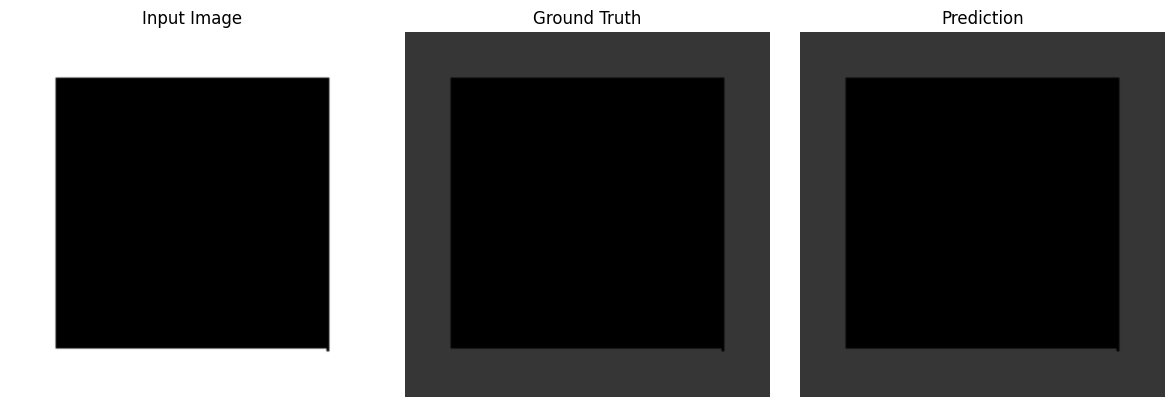

In [ ]:
plot_random_predictions(model, test_ds, device, num_samples=4)